$$\Huge \text{Develop RNN Models for} $$
$$\Huge \text{Human Activity Recognition Time Series Classification}$$
[src](https://machinelearningmastery.com/how-to-develop-rnn-models-for-human-activity-recognition-time-series-classification/)

$\large 1. $ Develop an LSTM Network Model

$\large 2. $ Develop a CNN-LSTM Network Model

$\large 3. $ Develop a ConvLSTM Network Model

# Activity Recognition Using Smartphones Dataset

# The six activities performed were as follows:

1. Walking
2. Walking Upstairs
3. Walking Downstairs
4. Sitting
5. Standing
6. Laying

# Description
1. The movement data recorded was the **x, y, and z accelerometer data** (linear acceleration) and **gyroscopic data (angular velocity)** from the **smart phone**, specifically a Samsung Galaxy S II. 

2. Observations were recorded at 50 Hz (i.e. **50 data points** per **second**). 

3. Each subject performed the sequence of **activities twice;** once with the device on their **left-hand-side** and once with the device on their **right-hand side.**

# The pre-processing steps included:

1. Pre-processing accelerometer and gyroscope using **noise filters.**
2. **Splitting** data into **fixed** windows of **2.56 seconds** (**128 = 50hz * 2.56s** data points) with **50% overlap**.
3. Splitting of accelerometer data into gravitational (total) and body motion components.
4. The dataset was split into **train (70%)** and **test (30%)** sets based on data for subjects

# download 

In [ ]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip

In [ ]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.names

# Develop an LSTM Network Model

$\large *$ We will develop a Long Short-Term Memory network model **(LSTM)** for the **human activity recognition** dataset.

$\large *$ **LSTM network** models are a type of recurrent neural network that are **able to learn and remember over long sequences** of input data.

$\large *$ They are intended for use with data that is **comprised of long sequences** of data, up to **200 to 400 time steps**. 

$\large *$ The model can support **multiple parallel sequences of input data,** such as each axis of the accelerometer and gyroscope data. The **model learns to extract features from sequences** of observations and how to **map the internal features to different activity types.**

$\large *$ The **benefit of using LSTMs for sequence classification** is that they **can learn from the raw time series data directly**, and in turn **do not require domain expertise** to manually engineer input features. The model can learn an internal representation of the time series data and ideally achieve comparable performance to models fit on a version of the dataset with engineered features.

## This section is divided into four parts

$\large 1. $ Load Data

$\large 2. $ Fit and Evaluate Model

$\large 3. $ Summarize Results

$\large 4. $ Complete Example

## $\large 1. $ Load Data

There are three main signal types in the raw data: 
1. Triaxial acceleration from the accelerometer (total acceleration) and the estimated body acceleration.,    
2.Triaxial Angular velocity from the gyroscope.   
3. A 561-feature vector with time and frequency domain variables.   
4. Its activity label.   
5. An identifier of the subject who carried out the experiment.

Each series of data has been partitioned into:
> **Overlapping 50%** and **windows size of** **2.56 seconds** of data, or **128=(2.56s * 50 samples/s) time steps**. 

In [104]:
import pandas as pd
import numpy as np
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *

In [105]:
# load a single file as a numpy array
def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values

In [106]:
def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = np.dstack(loaded)
    return loaded

In [107]:
def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    # load input data
    X = load_group(filenames, filepath)
    # load class output
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y

In [108]:
# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group('train', prefix + 'HARDataset/')
    print(trainX.shape, trainy.shape)
    # load all test
    testX, testy = load_dataset_group('test', prefix + 'HARDataset/')
    print(testX.shape, testy.shape)
    # zero-offset class values
    trainy = trainy - 1
    testy = testy - 1
    # one hot encode y
    trainy = to_categorical(trainy)
    testy = to_categorical(testy)
    print(trainX.shape, trainy.shape, testX.shape, testy.shape)
    return trainX, trainy, testX, testy

In [109]:
trainX, trainy, testX, testy = load_dataset()

(7352, 128, 9) (7352, 1)
(2947, 128, 9) (2947, 1)
(7352, 128, 9) (7352, 6) (2947, 128, 9) (2947, 6)


In [110]:
# %load /app/ml/00_Libs/DisplaySideBySide.py
import pandas as pd
from IPython.display import display, HTML

def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display(HTML(html_str.replace('table','table style="display:inline"')))

In [111]:
pre = 0
cur = pre + 1

In [113]:
display_side_by_side(pd.DataFrame(trainX[pre,64:74,:3]), pd.DataFrame(trainX[cur,0:10,:3]))

In [114]:
n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]

## Define model

In [117]:
model = Sequential()
model.add(LSTM(100, input_shape=(n_timesteps,n_features)))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

## Fit 

In [68]:
verbose, epochs, batch_size = 1, 15, 64
n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
# fit network
model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)

Epoch 1/15
7352/7352 [==============================] - 16s 2ms/step - loss: 1.2100 - accuracy: 0.4980
Epoch 2/15
7352/7352 [==============================] - 16s 2ms/step - loss: 0.7613 - accuracy: 0.6789
Epoch 3/15
7352/7352 [==============================] - 16s 2ms/step - loss: 0.5504 - accuracy: 0.7765
Epoch 4/15
7352/7352 [==============================] - 16s 2ms/step - loss: 0.4508 - accuracy: 0.8419
Epoch 5/15
7352/7352 [==============================] - 16s 2ms/step - loss: 0.2982 - accuracy: 0.8939
Epoch 6/15
7352/7352 [==============================] - 16s 2ms/step - loss: 0.2779 - accuracy: 0.9008
Epoch 7/15
7352/7352 [==============================] - 16s 2ms/step - loss: 0.2711 - accuracy: 0.9026
Epoch 8/15
7352/7352 [==============================] - 16s 2ms/step - loss: 0.1818 - accuracy: 0.9325
Epoch 9/15
7352/7352 [==============================] - 15s 2ms/step - loss: 0.2580 - accuracy: 0.9123
Epoch 10/15
7352/7352 [==============================] - 16s 2ms/step - l

## Evaluate model

In [72]:
_, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=1)
accuracy

2947/2947 [==============================] - 3s 1ms/step


0.9012554883956909

In [14]:
evaluate_model(trainX, trainy, testX, testy)

Epoch 1/15
7352/7352 [==============================] - 35s 5ms/sample - loss: 1.2084 - acc: 0.4879
Epoch 2/15
7352/7352 [==============================] - 33s 4ms/sample - loss: 0.8319 - acc: 0.6376
Epoch 3/15
7352/7352 [==============================] - 33s 4ms/sample - loss: 0.7635 - acc: 0.6783
Epoch 4/15
7352/7352 [==============================] - 33s 4ms/sample - loss: 0.5772 - acc: 0.7582
Epoch 5/15
7352/7352 [==============================] - 34s 5ms/sample - loss: 0.4555 - acc: 0.8293
Epoch 6/15
7352/7352 [==============================] - 33s 5ms/sample - loss: 0.3588 - acc: 0.8757
Epoch 7/15
7352/7352 [==============================] - 34s 5ms/sample - loss: 0.2931 - acc: 0.9017
Epoch 8/15
7352/7352 [==============================] - 33s 5ms/sample - loss: 0.2769 - acc: 0.9011
Epoch 9/15
7352/7352 [==============================] - 35s 5ms/sample - loss: 0.2080 - acc: 0.9266
Epoch 10/15
7352/7352 [==============================] - 36s 5ms/sample - loss: 0.2234 - acc: 0.9211

0.87275195

# Develop a CNN-LSTM Network Model [ref](https://ieeexplore.ieee.org/document/7178838/)

The **CNN LSTM architecture** involves **using Convolutional Neural Network (CNN) layers** for **feature extraction on input data** combined with LSTMs to support sequence prediction.

**CNN LSTMs were developed for visual time series prediction problems** and the **application of generating textual descriptions from sequences of images** (e.g. videos). Specifically, the problems of:

$\large 1.$ **Activity Recognition:**    Generating a textual description of an activity demonstrated in a sequence of images.   
$\large 2.$ **Image Description:** Generating a textual description of a single image.   
$\large 3.$ **Video Description:** Generating a textual description of a sequence of images.

## Process data

The **CNN LSTM model** will **read subsequence**s of the main sequence **in as blocks**, **extract features** from **each block,** then allow the **LSTM to interpret** the features extracted **from each block.**

**One approach** to implementing this model is to **split each window of 128 time steps** into subsequences **for the CNN model** to process. 

For example, **the 128 time steps** in each window can be **split into four subsequences of 32 time steps.**

In [73]:
# reshape data into time steps of sub-sequences
n_steps, n_length = 4, 32
trainX = trainX.reshape((trainX.shape[0], n_steps, n_length, n_features))
testX = testX.reshape((testX.shape[0], n_steps, n_length, n_features))

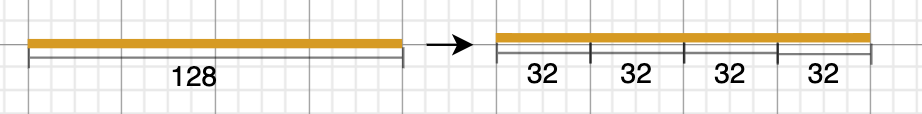

In [77]:
print(trainX.shape)
print(testX.shape)

(7352, 4, 32, 9)
(2947, 4, 32, 9)


### Prepaire data

In [119]:
trainX, trainy, testX, testy = load_dataset()
n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]

(7352, 128, 9) (7352, 1)
(2947, 128, 9) (2947, 1)
(7352, 128, 9) (7352, 6) (2947, 128, 9) (2947, 6)


### Reshape data into time steps of sub-sequences

In [120]:
n_steps, n_length = 4, 32
trainX = trainX.reshape((trainX.shape[0], n_steps, n_length, n_features))
testX = testX.reshape((testX.shape[0], n_steps, n_length, n_features))

In [121]:
print(trainX.shape)
print(testX.shape)

(7352, 4, 32, 9)
(2947, 4, 32, 9)


### Define model

In [94]:
# cnn lstm model
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.utils import to_categorical
from matplotlib import pyplot

model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None,n_length,n_features)))
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))
model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(100))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

The **entire CNN model can be wrapped in a TimeDistributed layer** to **allow the same CNN model to read in each of the four subsequences** in the window. The extracted features are **then flattened** and provided to the LSTM model to read, extracting its own features before a final mapping to an activity is made.

### Fit model

In [95]:
verbose, epochs, batch_size = 1, 25, 64

model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)


Epoch 1/25
7352/7352 [==============================] - 4s 496us/sample - loss: 0.6126 - acc: 0.7531
Epoch 2/25
7352/7352 [==============================] - 3s 348us/sample - loss: 0.2111 - acc: 0.9191
Epoch 3/25
7352/7352 [==============================] - 3s 347us/sample - loss: 0.1555 - acc: 0.9374
Epoch 4/25
7352/7352 [==============================] - 3s 347us/sample - loss: 0.1419 - acc: 0.9441s - loss: 0.1415
Epoch 5/25
7352/7352 [==============================] - 3s 344us/sample - loss: 0.1215 - acc: 0.9490
Epoch 6/25
7352/7352 [==============================] - 3s 363us/sample - loss: 0.1161 - acc: 0.9501
Epoch 7/25
7352/7352 [==============================] - 3s 358us/sample - loss: 0.1073 - acc: 0.9543
Epoch 8/25
7352/7352 [==============================] - 3s 350us/sample - loss: 0.1203 - acc: 0.9504
Epoch 9/25
7352/7352 [==============================] - 3s 352us/sample - loss: 0.1034 - acc: 0.9540
Epoch 10/25
7352/7352 [==============================] - 3s 348us/sample - 

## Full cnn lstm model

In [100]:
# cnn lstm model
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.utils import to_categorical
from matplotlib import pyplot

# load a single file as a numpy array
def load_file(filepath):
    dataframe = read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values

# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = dstack(loaded)
    return loaded

# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    # load input data
    X = load_group(filenames, filepath)
    # load class output
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y

# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group('train', prefix + 'HARDataset/')
    print(trainX.shape, trainy.shape)
    # load all test
    testX, testy = load_dataset_group('test', prefix + 'HARDataset/')
    print(testX.shape, testy.shape)
    # zero-offset class values
    trainy = trainy - 1
    testy = testy - 1
    # one hot encode y
    trainy = to_categorical(trainy)
    testy = to_categorical(testy)
    print(trainX.shape, trainy.shape, testX.shape, testy.shape)
    return trainX, trainy, testX, testy

# fit and evaluate a model
def evaluate_model(trainX, trainy, testX, testy):
    # define model
    verbose, epochs, batch_size = 1, 25, 64
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    # reshape data into time steps of sub-sequences
    n_steps, n_length = 4, 32
    trainX = trainX.reshape((trainX.shape[0], n_steps, n_length, n_features))
    testX = testX.reshape((testX.shape[0], n_steps, n_length, n_features))
    # define model
    model = Sequential()
    model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None,n_length,n_features)))
    model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))
    model.add(TimeDistributed(Dropout(0.5)))
    model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(100))
    model.add(Dropout(0.5))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)
    # evaluate model
    _, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
    return accuracy

# summarize scores
def summarize_results(scores):
    print(scores)
    m, s = mean(scores), std(scores)
    print('Accuracy: %.3f%% (+/-%.3f)' % (m, s))

# run an experiment
def run_experiment(repeats=10):
    # load data
    trainX, trainy, testX, testy = load_dataset()
    # repeat experiment
    scores = list()
    for r in range(repeats):
        score = evaluate_model(trainX, trainy, testX, testy)
        score = score * 100.0
        print('>#%d: %.3f' % (r+1, score))
        scores.append(score)
    # summarize results
    summarize_results(scores)

# run the experiment
run_experiment()

(7352, 128, 9) (7352, 1)
(2947, 128, 9) (2947, 1)
(7352, 128, 9) (7352, 6) (2947, 128, 9) (2947, 6)
Epoch 1/25
7352/7352 [==============================] - 4s 505us/sample - loss: 0.6290 - acc: 0.7379
Epoch 2/25
7352/7352 [==============================] - 3s 363us/sample - loss: 0.2566 - acc: 0.9018
Epoch 3/25
7352/7352 [==============================] - 3s 351us/sample - loss: 0.1531 - acc: 0.9406
Epoch 4/25
7352/7352 [==============================] - 3s 351us/sample - loss: 0.1356 - acc: 0.9461
Epoch 5/25
7352/7352 [==============================] - 3s 359us/sample - loss: 0.1178 - acc: 0.9479
Epoch 6/25
7352/7352 [==============================] - 3s 361us/sample - loss: 0.1270 - acc: 0.9456
Epoch 7/25
7352/7352 [==============================] - 3s 357us/sample - loss: 0.1066 - acc: 0.9544
Epoch 8/25
7352/7352 [==============================] - 3s 361us/sample - loss: 0.0991 - acc: 0.9557
Epoch 9/25
7352/7352 [==============================] - 3s 355us/sample - loss: 0.1056 - acc

7352/7352 [==============================] - 3s 388us/sample - loss: 0.1230 - acc: 0.9497
Epoch 6/25
7352/7352 [==============================] - 3s 401us/sample - loss: 0.1272 - acc: 0.9426
Epoch 7/25
7352/7352 [==============================] - 3s 386us/sample - loss: 0.1098 - acc: 0.9539
Epoch 8/25
7352/7352 [==============================] - 3s 390us/sample - loss: 0.1070 - acc: 0.9538
Epoch 9/25
7352/7352 [==============================] - 3s 391us/sample - loss: 0.1051 - acc: 0.9551
Epoch 10/25
7352/7352 [==============================] - 3s 379us/sample - loss: 0.1203 - acc: 0.9498
Epoch 11/25
7352/7352 [==============================] - 3s 399us/sample - loss: 0.1077 - acc: 0.9551
Epoch 12/25
7352/7352 [==============================] - 3s 394us/sample - loss: 0.1026 - acc: 0.9531
Epoch 13/25
7352/7352 [==============================] - 3s 389us/sample - loss: 0.0984 - acc: 0.9581
Epoch 14/25
7352/7352 [==============================] - 3s 387us/sample - loss: 0.0926 - acc: 0.9

7352/7352 [==============================] - 3s 398us/sample - loss: 0.1096 - acc: 0.9547
Epoch 11/25
7352/7352 [==============================] - 3s 390us/sample - loss: 0.0981 - acc: 0.9553
Epoch 12/25
7352/7352 [==============================] - 3s 392us/sample - loss: 0.0973 - acc: 0.9563
Epoch 13/25
7352/7352 [==============================] - 3s 389us/sample - loss: 0.0928 - acc: 0.9570
Epoch 14/25
7352/7352 [==============================] - 3s 376us/sample - loss: 0.0990 - acc: 0.9577
Epoch 15/25
7352/7352 [==============================] - 3s 381us/sample - loss: 0.1079 - acc: 0.9544
Epoch 16/25
7352/7352 [==============================] - 3s 387us/sample - loss: 0.0884 - acc: 0.9592
Epoch 17/25
7352/7352 [==============================] - 3s 379us/sample - loss: 0.0880 - acc: 0.9584
Epoch 18/25
7352/7352 [==============================] - 3s 390us/sample - loss: 0.0808 - acc: 0.9626
Epoch 19/25
7352/7352 [==============================] - 3s 386us/sample - loss: 0.0791 - acc:

7352/7352 [==============================] - 3s 386us/sample - loss: 0.0991 - acc: 0.9551
Epoch 16/25
7352/7352 [==============================] - 3s 393us/sample - loss: 0.0964 - acc: 0.9547
Epoch 17/25
7352/7352 [==============================] - 3s 388us/sample - loss: 0.0859 - acc: 0.9585
Epoch 18/25
7352/7352 [==============================] - 3s 388us/sample - loss: 0.0857 - acc: 0.9587
Epoch 19/25
7352/7352 [==============================] - 3s 394us/sample - loss: 0.0860 - acc: 0.9606
Epoch 20/25
7352/7352 [==============================] - 3s 396us/sample - loss: 0.0766 - acc: 0.9611
Epoch 21/25
7352/7352 [==============================] - 3s 393us/sample - loss: 0.0890 - acc: 0.9591
Epoch 22/25
7352/7352 [==============================] - 3s 387us/sample - loss: 0.0846 - acc: 0.9592
Epoch 23/25
7352/7352 [==============================] - 3s 394us/sample - loss: 0.0738 - acc: 0.9615
Epoch 24/25
7352/7352 [==============================] - 3s 392us/sample - loss: 0.0738 - acc:

# Develop a ConvLSTM Network Model [ref](https://arxiv.org/abs/1506.04214v1)

$\large 1. $ A further **extension of the CNN LSTM** idea is to **perform the convolutions of the CNN** (e.g. how the CNN reads the input sequence data) **as part of the LSTM.**

$\large 2. $ **This combination** is called a **Convolutional LSTM,** or **ConvLSTM** for short, and **like the CNN LSTM is also used for spatio-temporal data.**

$\large 3. $**Unlike** an LSTM that **reads the data in directly** in order to calculate internal state and state transitions, and **unlike the CNN LSTM that is interpreting the output from CNN models**, the **ConvLSTM** is using **convolutions directly as part of reading input** into the LSTM units themselves.

The **ConvLSTM2D** class, by default, expects input data to have the shape:

>**(samples, time, rows, cols, channels)**

Each time step of data is defined as **an image of (rows * columns)** data points.

* In the previous section, we divided a given window of data **(128 time steps)** into **four subsequences of 32 time steps.** 

> * We **can use this same subsequence approach** in defining the **ConvLSTM2D input** where the **number of time steps** is **the number of subsequences in the window**,    
> * the number of rows is 1 as we are working with one-dimensional data, and the number of columns represents the number of time steps in the subsequence, in this case 32.

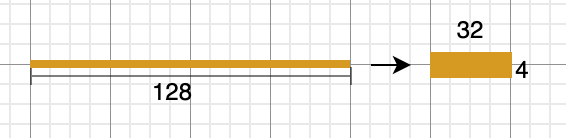

**For this chosen framing of the problem, the input for the ConvLSTM2D would therefore be:**

$\large 1. $ **Samples:** n, for the number of windows in the dataset.  

$\large 2. $ **Time:** 4, for the four subsequences that we split a window of 128 time steps into.

$\large 3. $ **Rows:** 1, for the one-dimensional shape of each subsequence.

$\large 4. $ **Columns:** 32, for the 32 time steps in an input subsequence.

$\large 5. $ **Channels:** 9, for the nine input variables.

### Prepare data

In [122]:
trainX, trainy, testX, testy = load_dataset()
n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
# reshape into subsequences (samples, time steps, rows, cols, channels)
n_steps, n_length = 4, 32
trainX = trainX.reshape((trainX.shape[0], n_steps, 1, n_length, n_features))
testX = testX.reshape((testX.shape[0], n_steps, 1, n_length, n_features))

(7352, 128, 9) (7352, 1)
(2947, 128, 9) (2947, 1)
(7352, 128, 9) (7352, 6) (2947, 128, 9) (2947, 6)


In [123]:
trainX.shape

(7352, 4, 1, 32, 9)

In [124]:
testX.shape

(2947, 4, 1, 32, 9)

### Define model

In [103]:
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import ConvLSTM2D
from keras.utils import to_categorical
from matplotlib import pyplot

# define model
model = Sequential()
model.add(ConvLSTM2D(filters=64, kernel_size=(1,3), activation='relu', input_shape=(n_steps, 1, n_length, n_features)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))

### Full convlstm model

In [126]:
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import ConvLSTM2D
from keras.utils import to_categorical
from matplotlib import pyplot

# load a single file as a numpy array
def load_file(filepath):
    dataframe = read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values

# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = dstack(loaded)
    return loaded

# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    # load input data
    X = load_group(filenames, filepath)
    # load class output
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y

# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group('train', prefix + 'HARDataset/')
    print(trainX.shape, trainy.shape)
    # load all test
    testX, testy = load_dataset_group('test', prefix + 'HARDataset/')
    print(testX.shape, testy.shape)
    # zero-offset class values
    trainy = trainy - 1
    testy = testy - 1
    # one hot encode y
    trainy = to_categorical(trainy)
    testy = to_categorical(testy)
    print(trainX.shape, trainy.shape, testX.shape, testy.shape)
    return trainX, trainy, testX, testy

# fit and evaluate a model
def evaluate_model(trainX, trainy, testX, testy):
    # define model
    verbose, epochs, batch_size = 1, 100, 64
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    # reshape into subsequences (samples, time steps, rows, cols, channels)
    n_steps, n_length = 4, 32
    trainX = trainX.reshape((trainX.shape[0], n_steps, 1, n_length, n_features))
    testX = testX.reshape((testX.shape[0], n_steps, 1, n_length, n_features))
    # define model
    model = Sequential()
    model.add(ConvLSTM2D(filters=64, kernel_size=(1,3), activation='relu', input_shape=(n_steps, 1, n_length, n_features)))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)
    # evaluate model
    _, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
    return accuracy

# summarize scores
def summarize_results(scores):
    print(scores)
    m, s = mean(scores), std(scores)
    print('Accuracy: %.3f%% (+/-%.3f)' % (m, s))

# run an experiment
def run_experiment(repeats=1):
    # load data
    trainX, trainy, testX, testy = load_dataset()
    # repeat experiment
    scores = list()
    for r in range(repeats):
        score = evaluate_model(trainX, trainy, testX, testy)
        score = score * 100.0
        print('>#%d: %.3f' % (r+1, score))
        scores.append(score)
    # summarize results
    summarize_results(scores)

# run the experiment
run_experiment()

(7352, 128, 9) (7352, 1)
(2947, 128, 9) (2947, 1)
(7352, 128, 9) (7352, 6) (2947, 128, 9) (2947, 6)
Epoch 1/100
7352/7352 [==============================] - 5s 723us/step - loss: 0.6073 - accuracy: 0.7616
Epoch 2/100
7352/7352 [==============================] - 4s 511us/step - loss: 0.2211 - accuracy: 0.9115
Epoch 3/100
7352/7352 [==============================] - 4s 517us/step - loss: 0.1674 - accuracy: 0.9347
Epoch 4/100
7352/7352 [==============================] - 4s 526us/step - loss: 0.1370 - accuracy: 0.9406
Epoch 5/100
7352/7352 [==============================] - 4s 525us/step - loss: 0.1294 - accuracy: 0.9470
Epoch 6/100
7352/7352 [==============================] - 4s 518us/step - loss: 0.1201 - accuracy: 0.9502
Epoch 7/100
7352/7352 [==============================] - 4s 521us/step - loss: 0.1172 - accuracy: 0.9505
Epoch 8/100
7352/7352 [==============================] - 4s 520us/step - loss: 0.1219 - accuracy: 0.9476
Epoch 9/100
7352/7352 [==============================] - 4s 

7352/7352 [==============================] - 4s 517us/step - loss: 0.0266 - accuracy: 0.9908
Epoch 78/100
7352/7352 [==============================] - 4s 507us/step - loss: 0.0425 - accuracy: 0.9856
Epoch 79/100
7352/7352 [==============================] - 4s 524us/step - loss: 0.0247 - accuracy: 0.9902
Epoch 80/100
7352/7352 [==============================] - 4s 534us/step - loss: 0.0374 - accuracy: 0.9888
Epoch 81/100
7352/7352 [==============================] - 4s 523us/step - loss: 0.0265 - accuracy: 0.9887
Epoch 82/100
7352/7352 [==============================] - 4s 515us/step - loss: 0.0213 - accuracy: 0.9905
Epoch 83/100
7352/7352 [==============================] - 4s 524us/step - loss: 0.0207 - accuracy: 0.9924
Epoch 84/100
7352/7352 [==============================] - 4s 518us/step - loss: 0.0216 - accuracy: 0.9902
Epoch 85/100
7352/7352 [==============================] - 4s 520us/step - loss: 0.0221 - accuracy: 0.9905
Epoch 86/100
7352/7352 [==============================] - 4